In [1]:
import tensorflow as tf

2025-08-16 12:41:33.546304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755348093.742167      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755348093.800690      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert tf.config.list_physical_devices('GPU'), "No GPU detected: Check your Kaggle environment settings."

Num GPUs Available: 1


In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
# from keras_flops import get_flops


IMG_SIZE = (224, 224)  # Adjust as needed
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
INITIAL_LR = 0.001
EPOCHS = 100
SEED = 42

train_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/train'
val_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/val'
test_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/test'

datagen_args = dict(rescale=1./255)
train_gen = ImageDataGenerator(**datagen_args)
val_gen = ImageDataGenerator(**datagen_args)
test_gen = ImageDataGenerator(**datagen_args)
train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)
val_flow = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
num_classes = train_flow.num_classes

Found 14219 images belonging to 43 classes.
Found 11955 images belonging to 43 classes.
Found 11958 images belonging to 43 classes.


In [4]:
base_model = EfficientNetV2B0(
    include_top=False, 
    weights='imagenet', 
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = True

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(DROPOUT_RATE)(x)

x = Dense(128, activation='relu')(x)

output = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)


optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LR, 
    weight_decay=0.01
)

print("Compiling model...")
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


I0000 00:00:1755348113.433895      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Compiling model...


In [5]:
print("\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")


Model Summary:
Total parameters: 7,932,795
Trainable parameters: 7,868,603


In [6]:
checkpoint_cb = ModelCheckpoint(
    "best_EfficientNetV2B0_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10, 
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]

print("efficientnetv2b0 Starting training ")
!curl -d "Train Start" ntfy.sh/model_complete

# Train the whole model on your dataset
history = model.fit(
    train_flow,
    epochs=EPOCHS,
    validation_data=val_flow,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")
!curl -d "efficientnetv2b0 Train Complete" ntfy.sh/model_complete

with open('training_history.json', 'w') as f:
    json.dump(history.history,f)
    

efficientnetv2b0 Starting training 
{"id":"6a4oEraYHk1Z","time":1755348118,"expires":1755391318,"event":"message","topic":"model_complete","message":"Train Start"}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1755348188.398152     117 service.cc:148] XLA service 0x7de118034e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755348188.399110     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755348194.732172     117 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1755348205.605080     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755348205.789341     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755348206.255569     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755348206.4623

  1/445 ━━━━━━━━━━━━━━━━━━━━ 13:47:35 112s/step - accuracy: 0.0000e+00 - loss: 4.2972

I0000 00:00:1755348230.818118     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


429/445 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.1719 - loss: 3.0938

E0000 00:00:1755348328.929544     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755348329.111894     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755348329.532865     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755348329.738337     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.1760 - loss: 3.0681
Epoch 1: val_accuracy improved from -inf to 0.03940, saving model to best_EfficientNetV2B0_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 322s 474ms/step - accuracy: 0.1762 - loss: 3.0665 - val_accuracy: 0.0394 - val_loss: 4.5334 - learning_rate: 0.0010
Epoch 2/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5220 - loss: 1.3497
Epoch 2: val_accuracy did not improve from 0.03940
445/445 ━━━━━━━━━━━━━━━━━━━━ 91s 203ms/step - accuracy: 0.5221 - loss: 1.3493 - val_accuracy: 0.0182 - val_loss: 7.0192 - learning_rate: 0.0010
Epoch 3/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6815 - loss: 0.8849
Epoch 3: val_accuracy did not improve from 0.03940
445/445 ━━━━━━━━━━━━━━━━━━━━ 89s 201ms/step - accuracy: 0.6815 - loss: 0.8848 - val_accuracy: 0.0168 - val_loss: 7.9552 - learning_rate: 0.0010
Epoch 4/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7748 - loss: 0.6404
Epoch 4: val_accuracy

374/374 ━━━━━━━━━━━━━━━━━━━━ 123s 309ms/step
Test Loss: 0.2398
Test Accuracy: 0.9543
Precision: 0.9155
Recall: 0.9298
F1 Score: 0.9213
Parameters: 7932795


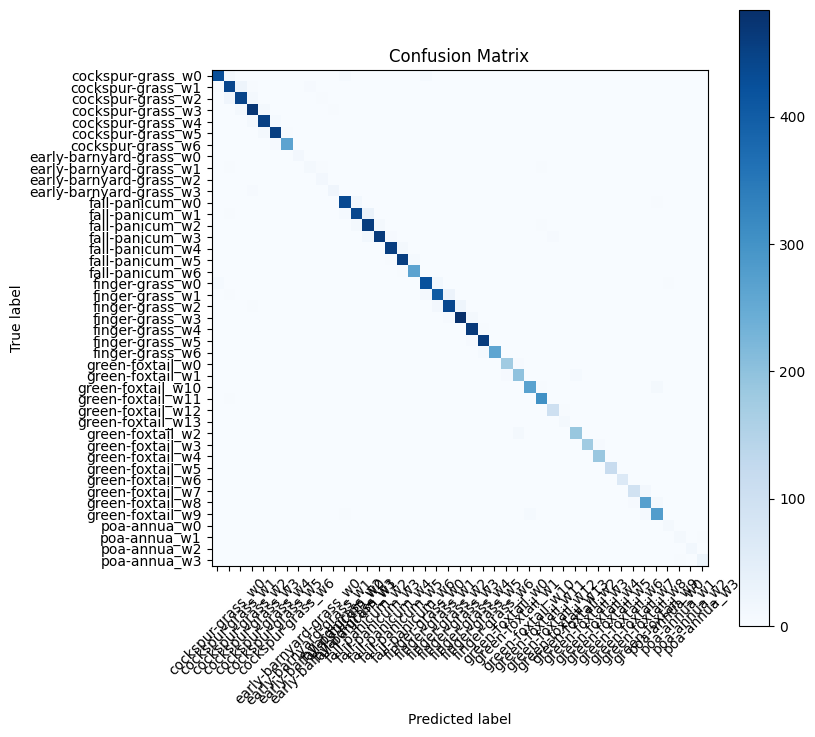

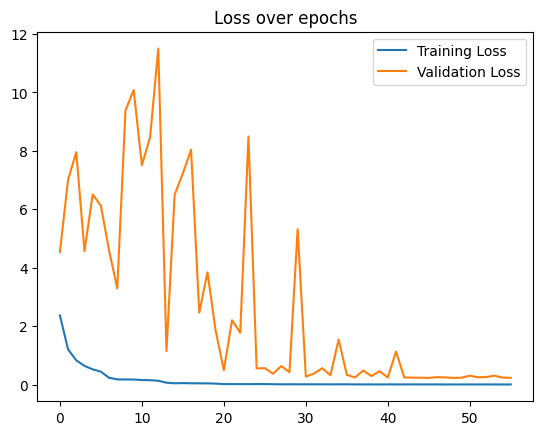

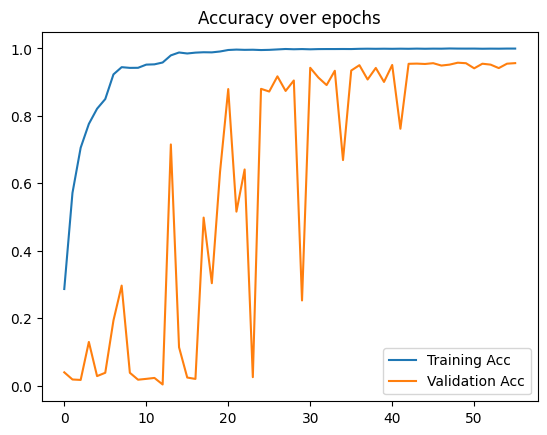

In [7]:
test_flow.reset()
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = list(test_flow.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
test_loss, test_acc = model.evaluate(test_flow, verbose=0)

# Precision, Recall, F1 (macro avg)
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]

# GFLOPS & Params
# flops = get_flops(model, batch_size=1)
num_params = model.count_params()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# print(f"GFLOPS: {flops/1e9:.4f}")
print(f"Parameters: {num_params}")

# Confusion Matrix 
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Loss/Accuracy Curves 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(); plt.title("Loss over epochs"); plt.show()
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.legend(); plt.title("Accuracy over epochs"); plt.show()


In [8]:
model.save('densenet_final_model.keras')
model.save_weights('densenet_final.weights.h5')

| Model            |   Params |   Test Loss |   Test Acc |   Precision |   Recall |     F1 |
|:-----------------|---------:|------------:|-----------:|------------:|---------:|-------:|
| EfficientNetV2B0 |  7932795 |      0.2398 |     0.9543 |      0.9155 |   0.9298 | 0.9213 |


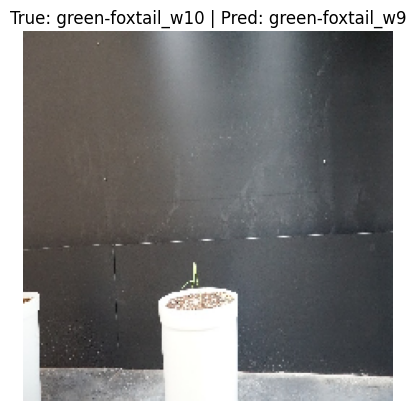

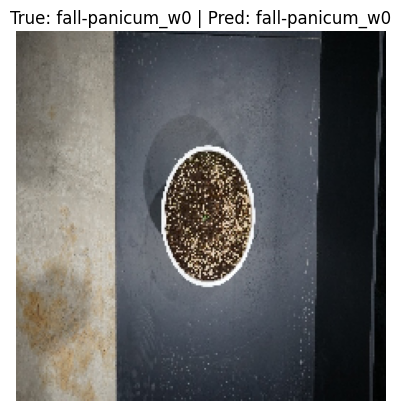

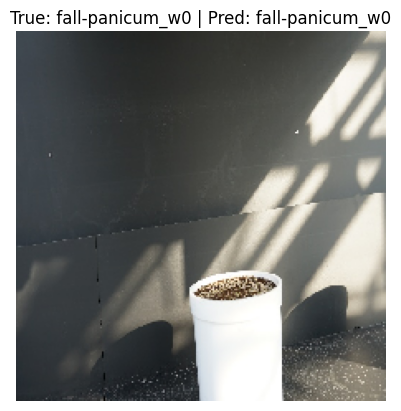

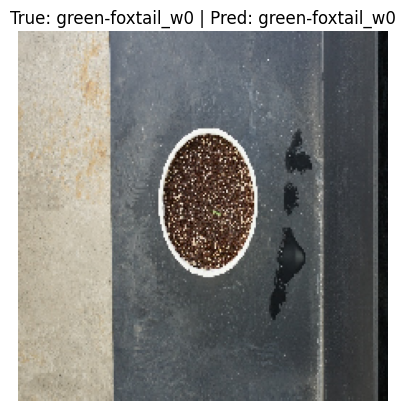

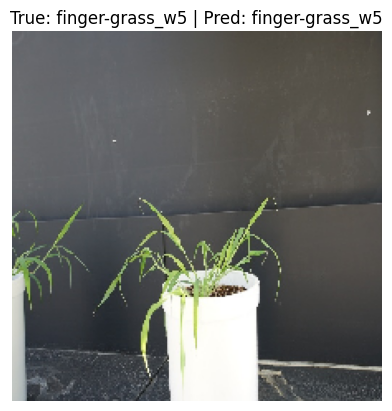

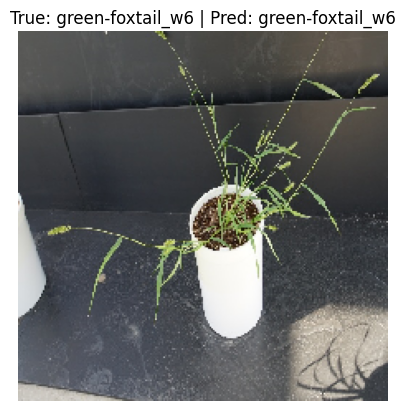

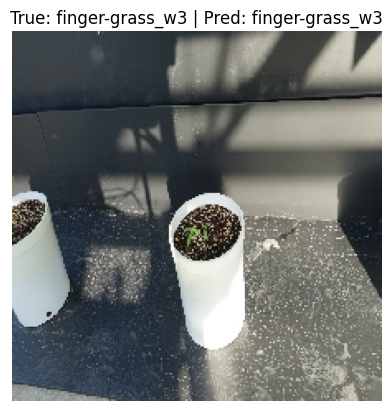

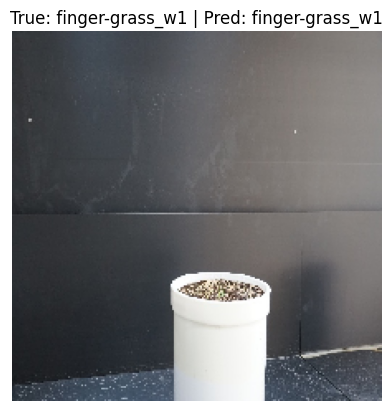

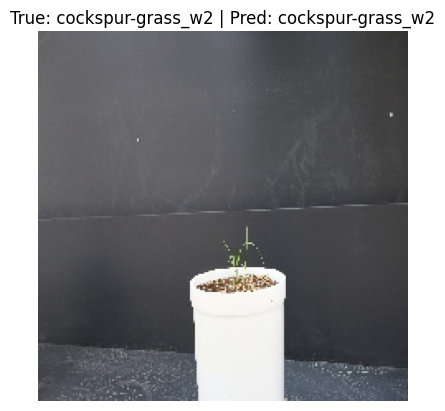

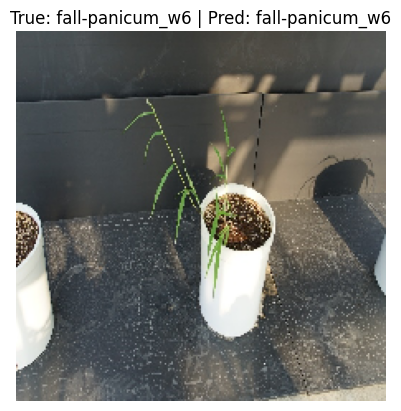

{"id":"QFGlRR3HGvNv","time":1755353584,"expires":1755396784,"event":"message","topic":"model_complete","message":"Finished"}


In [9]:
import pandas as pd
results = {
    "Model": ["EfficientNetV2B0"],
    "Params": [num_params],
    # "GFLOPS": [f"{flops/1e9:.4f}"],
    "Test Loss": [f"{test_loss:.4f}"],
    "Test Acc": [f"{test_acc:.4f}"],
    "Precision": [f"{precision:.4f}"],
    "Recall": [f"{recall:.4f}"],
    "F1": [f"{f1:.4f}"]
}
df = pd.DataFrame(results)
print(df.to_markdown(index=False))


import random
sample_idx = random.sample(range(test_flow.n), 10)
for idx in sample_idx:
    img_path = test_flow.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    true_label = target_names[y_true[idx]]
    pred_label = target_names[y_pred[idx]]
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()

!curl -d "Finished" ntfy.sh/model_complete